In [ ]:
import pandas as pd
import numpy as np
import os
import sys

In [ ]:
#function for collating data
def read_data(address):
    df_original = pd.DataFrame(columns=['ID', 'Time', 'Date', 'Altitude', 'Speed', 'Heading', 'Lat', 'Lon',
       'Age', 'Range', 'Bearing', 'Tail', 'AltisGNSS', 'Metar'])
    for subdir, dirs, files in os.walk(address):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".csv"):
                print(filepath)
                new_df = pd.read_csv(filepath, low_memory=False, header=None, skiprows=1, index_col = False, 
                               names=['ID', 'Time', 'Date', 'Altitude', 'Speed', 'Heading', 'Lat', 'Lon',
                               'Age', 'Range', 'Bearing', 'Tail', 'AltisGNSS', 'Metar'])
                df_original = df_original.append(new_df)
    return df_original

In [ ]:
# Enter flight folder path here
path = '7days2/raw_data/'
# Reading and collating flight data
#df_flight = read_data(path)
# Read Flight Data
df_flight = pd.read_csv('out.csv', low_memory=False)
df_flight['ID'] = df_flight['ID'].astype(int)
df_flight.drop(df_flight[(df_flight['Speed'].isnull())].index, inplace=True)
df_flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9282419 entries, 0 to 9330849
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ID        int32  
 1   Time      object 
 2   Date      object 
 3   Altitude  int64  
 4   Speed     float64
 5   Heading   float64
 6   Lat       float64
 7   Lon       float64
 8   Age       float64
 9   Range     float64
 10  Bearing   float64
 11  Tail      object 
 12  Metar     object 
dtypes: float64(7), int32(1), int64(1), object(4)
memory usage: 956.1+ MB


In [ ]:
df_flight.head()

,ID,Time,Date,Altitude,Speed,Heading,Lat,Lon,Age,Range,Bearing,Tail,Metar
0,11230936,23:10:39.838,01/19/2021,38000,364.0,304.0,40.472626,-80.338870,2.898249,47.248304,-135.717486,SWA1456,KBTP 192310Z AUTO 22005KT 10SM OVC090 01/M06 A...
1,10672426,23:10:39.780,01/19/2021,36075,343.0,304.0,40.359394,-80.113365,2.898340,48.490544,-163.356299,N283AK,KBTP 192310Z AUTO 22005KT 10SM OVC090 01/M06 A...
2,12583405,23:10:39.898,01/19/2021,43000,392.0,186.0,40.625200,-80.247620,2.898398,30.343740,-123.874832,ASP489,KBTP 192310Z AUTO 22005KT 10SM OVC090 01/M06 A...
3,11230936,23:10:39.838,01/19/2021,38000,364.0,304.0,40.472626,-80.338870,3.899393,47.248304,-135.717486,SWA1456,KBTP 192310Z AUTO 22005KT 10SM OVC090 01/M06 A...
4,10672426,23:10:39.780,01/19/2021,36075,343.0,304.0,40.359394,-80.113365,3.899472,48.490544,-163.356299,N283AK,KBTP 192310Z AUTO 22005KT 10SM OVC090 01/M06 A...


In [ ]:
# Dataframe for flight details
df_flight_details = df_flight[['ID','Tail']].drop_duplicates().reset_index(drop=True)
df_flight_details['ID'] = df_flight_details['ID'].astype(int)
df_flight_details.head()

,ID,Tail
0,11230936,SWA1456
1,10672426,N283AK
2,12583405,ASP489
3,10701829,N311RF
4,10561439,N1737


In [ ]:
# Read Weather Data
df_weather = pd.read_csv('weather_data/weather.csv', low_memory=False)

df_weather['Date'] = pd.to_datetime(df_weather['valid']).dt.date
df_weather['Time'] = pd.to_datetime(df_weather['valid']).dt.time
df_weather['Time'] = df_weather['Time'].astype(str)

In [ ]:
# Creating the tables and Deleting the old instances of the tables
def db_createTableSchema():
    import sqlite3

    conn = sqlite3.connect('documents.db')
    c = conn.cursor()

    c.execute('''DROP TABLE IF EXISTS weather ''')
    c.execute('''DROP TABLE IF EXISTS flight ''')
    c.execute('''DROP TABLE IF EXISTS idtotail ''')
    
    wther_query = '''CREATE TABLE IF NOT EXISTS weather (
                        Date DATE NOT NULL,
                        Time VARCHAR(8),
                        tmpf VARCHAR(100),
                        dwpf VARCHAR(100),
                        relh VARCHAR(100),
                        drct VARCHAR(100),
                        sknt VARCHAR(100),
                        p01i VARCHAR(100),
                        alti VARCHAR(100),
                        mslp VARCHAR(100),
                        vsby VARCHAR(100),
                        gust VARCHAR(100),
                        skyc1 VARCHAR(100),
                        feel VARCHAR(100),
                        metar Text,
                        CONSTRAINT WeatherUnq PRIMARY KEY (Date,Time));'''
    c.execute(wther_query)
    print('Table weather created.');
    
    itail_query = '''CREATE TABLE IF NOT EXISTS idtotail ( 
                        Id INT PRIMARY KEY NOT NULL,
                        Tail VARCHAR(100));'''
    c.execute(itail_query)
    print('Table idtotail created.');
    
    flght_query = '''CREATE TABLE IF NOT EXISTS flight (
                        ID INT NOT NULL,
                        Date DATE NOT NULL,
                        Time VARCHAR(8) NOT NULL,
                        Altitude VARCHAR(100),
                        Speed VARCHAR(100),
                        Heading VARCHAR(100),
                        Lat VARCHAR(100),
                        Lon VARCHAR(100),
                        Angle VARCHAR(100),
                        Range VARCHAR(100),
                        Bearing VARCHAR(100),
                        Metar VARCHAR(500),
                        CONSTRAINT FlightUnq PRIMARY KEY (ID,Date,Time),
                        FOREIGN KEY (Metar) REFERENCES weather(metar),
                        FOREIGN KEY (ID) REFERENCES idtotail(ID));'''
    c.execute(flght_query)
    print('Table flight created.');
    
# Deleting the content of the tables
def db_delete_table_content():
    import sqlite3

    conn = sqlite3.connect('documents.db')
    c = conn.cursor()

    wther_query = """ DELETE FROM weather"""
    c.execute(wther_query)
    print("Content of table 'weather' has been deleted")
    
    flght_query = """ DELETE FROM flight"""
    c.execute(flght_query)
    print("Content of table 'flight' has been deleted")
    
    itail_query = """ DELETE FROM idtotail"""
    c.execute(itail_query)
    print("Content of table 'idtotail' has been deleted")
    conn.commit()

# Inserting data into the tables from files created
def db_insert_data():
    import sqlite3
    conn = sqlite3.connect('documents.db')
    c = conn.cursor()
    
    # Insert all data in tables
    for index, row in df_weather.iterrows():
        
        wther_query = """INSERT or IGNORE INTO
                            weather(Date,Time,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyc1,feel,metar) 
                            values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)"""
        c.execute(wther_query, (row['Date'], row['Time'],
                                row['tmpf'], row['dwpf'],
                                row['relh'], row['drct'],
                                row['sknt'], row['p01i'],
                                row['alti'], row['mslp'],
                                row['vsby'], row['gust'],
                                row['skyc1'], row['feel'],
                                row['metar']))
        
    for index, row in df_flight_details.iterrows():
        itail_query = """INSERT or IGNORE INTO 
                            idtotail(ID,Tail) 
                            values(?,?)"""
        c.execute(itail_query, (row['ID'], row['Tail']))
        
    for index, row in df_flight.iterrows():
        
        flght_query = """INSERT or IGNORE INTO
                            flight(ID,Date,Time,Altitude,Speed,Heading,Lat,Lon,Angle,Range,Bearing,Metar) 
                            values(?,?,?,?,?,?,?,?,?,?,?,?)"""
        c.execute(flght_query, (row['ID'], row['Date'],
                                row['Time'], row['Altitude'],
                                row['Speed'], row['Heading'],
                                row['Lat'], row['Lon'],
                                row['Age'], row['Range'],
                                row['Bearing'], row['Metar'],
                                ))
        
    print("Insertion into tables are completed\n")
       
    conn.commit()
    c.close()

In [ ]:
# Perform database actions
db_createTableSchema()
db_delete_table_content()
%time db_insert_data()

Table weather created.
Table idtotail created.
Table flight created.
Content of table 'weather' has been deleted
Content of table 'flight' has been deleted
Content of table 'idtotail' has been deleted
Insertion into tables are completed

Wall time: 48min 34s


In [ ]:
import sqlite3
conn = sqlite3.connect('documents.db') 
c = conn.cursor()

In [ ]:
%%time
# Pandas SQL query fetching time
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM weather where metar = 'KBTP 150035Z AUTO 07005KT 10SM CLR 27/13 A3000 RMK T02700130 MADISHF'
                               ''', conn)

Wall time: 13.8 s


In [ ]:
%%time
# SQLlite SQL query fetching time
sql_query_data = "SELECT count(DISTINCT ID) as CountID,skyc1 FROM flight as f join weather as w on f.metar = w.metar group by skyc1 order by CountID DESC LIMIT 5"
sql_query = c.execute (sql_query_data)
df_res_weather = pd.DataFrame(sql_query, columns = ['CountID', 'Weather_Condition'])
df_res_weather.head()

Wall time: 19 s


,CountID,Weather_Condition
0,2467,CLR
1,1379,OVC
2,1364,BKN
3,1253,FEW
4,1015,SCT


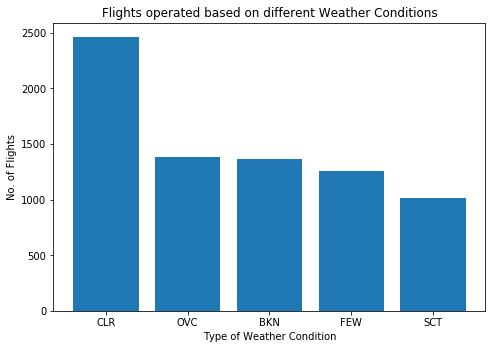

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Type of Weather Condition')
ax.set_ylabel('No. of Flights')
ax.set_title('Flights operated based on different Weather Conditions')
ax.bar(df_res_weather['Weather_Condition'],df_res_weather['CountID'])
plt.show()

In [ ]:
%%time
# SQLlite SQL query fetching time
sql_query_data = "SELECT avg(sknt) as WindSpeed, avg(Speed) as AircraftSpeed,count(DISTINCT ID), f.date FROM flight as f join weather as w on f.metar = w.metar group by f.date having f.date>'09/25/2020' and f.date<'10/02/2020'"
sql_query = c.execute (sql_query_data)
df_res_weather = pd.DataFrame(sql_query, columns = ['WindSpeed', 'AircraftSpeed','Count Flights','Date'])
df_res_weather.head()

Wall time: 4.81 s


,WindSpeed,AircraftSpeed,Count Flights,Date
0,3.191114,110.310111,148,09/26/2020
1,6.706347,124.114413,158,09/27/2020
2,7.434499,123.904007,127,09/28/2020
3,3.110185,155.190972,110,09/29/2020
4,10.960687,170.051569,114,09/30/2020


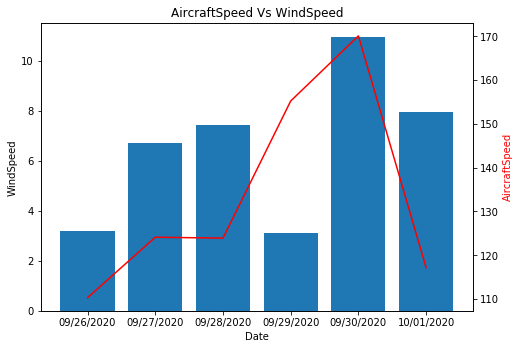

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Date')
ax.set_ylabel('WindSpeed')
ax.set_title('AircraftSpeed Vs WindSpeed')
ax.bar(df_res_weather['Date'],df_res_weather['WindSpeed'])

#Set up ax2 to be the second y axis with x shared
ax2 = ax.twinx()
#Plot a line
ax2.plot(df_res_weather['Date'], df_res_weather['AircraftSpeed'], 'r-')

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('AircraftSpeed', color='r')
plt.show()

In [ ]:
%%time
# SQLlite SQL query fetching time
sql_query_data = "SELECT avg(Altitude), avg(sknt) as WindSpeed, avg(Speed) as AircraftSpeed, f.Date FROM flight as f join weather as w on f.metar = w.metar group by f.Date having f.date>'01/19/2021' and f.date<'01/25/2021'"
sql_query = c.execute (sql_query_data)
df_res_weather = pd.DataFrame(sql_query, columns = ['Altitude', 'WindSpeed', 'AircraftSpeed', 'Date'])
df_res_weather['WindSpeed'] = df_res_weather['WindSpeed'].astype(float)
df_res_weather['AircraftSpeed'] = df_res_weather['AircraftSpeed'].astype(float)
df_res_weather['TotalSpeed'] = df_res_weather['WindSpeed'] + df_res_weather['AircraftSpeed'] 
df_res_weather.head()

Wall time: 4.74 s


,Altitude,WindSpeed,AircraftSpeed,Date,TotalSpeed
0,6167.995223,7.679142,172.575344,01/20/2021,180.254486
1,5545.926334,11.738671,143.897424,01/21/2021,155.636095
2,5864.637131,10.001848,161.149077,01/22/2021,171.150925
3,3868.419034,6.321868,118.954995,01/23/2021,125.276863
4,3510.420534,4.658574,116.722597,01/24/2021,121.381171


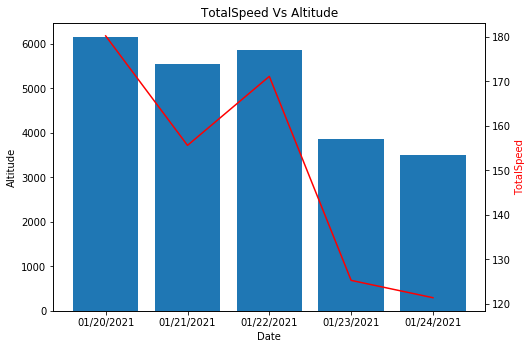

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Date')
ax.set_ylabel('Altitude')
ax.set_title('TotalSpeed Vs Altitude')
ax.bar(df_res_weather['Date'],df_res_weather['Altitude'])

#Set up ax2 to be the second y axis with x shared
ax2 = ax.twinx()
#Plot a line
ax2.plot(df_res_weather['Date'], df_res_weather['TotalSpeed'], 'r-')

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('TotalSpeed', color='r')
plt.show()

In [ ]:
%%time
# SQLlite SQL query fetching time
sql_query_data = "SELECT * FROM weather"
sql_query = c.execute (sql_query_data)
df_res_weather = pd.DataFrame(sql_query, columns = ['Date', 'Time', 'tmpf','dwpf','relh','drct',
                                        'sknt','p01i','alti','mslp','vsby','gust','skyc1','feel','metar'])

sql_query_data = "SELECT * FROM flight"
sql_query = c.execute (sql_query_data)
df_res_flight = pd.DataFrame(sql_query, columns = ['ID','Date','Time','Altitude','Speed','Heading','Lat','Lon',
                                                    'Angle','Range','Bearing','Metar'])

df_res_weather.to_csv('Weather_DB.csv', index=False)
df_res_flight.to_csv('Flight_DB.csv', index=False)

Wall time: 23min 3s


In [ ]:
# Read Weather Data
df_total = pd.read_csv('out.csv', low_memory=False)
len(df_total)

9330850

In [ ]:
# splitting dataframe by row index
df1 = df_total.iloc[:4700000,:]
df2 = df_total.iloc[4700001:,:]
df1.to_csv('out1.csv', index=False)
df2.to_csv('out2.csv', index=False)